In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import shutil
import sys
import os


randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "svg"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

sys.path.append("..")

from swarmalatorlib.template import Swarmalators2D

In [2]:
class MinimalPredator(Swarmalators2D):
    def __init__(self, agentsNum: int, dt: float, 
                 a: float, b: float, c: float, p: float,
                 randomSeed: int = 100, 
                 tqdm: bool = False, savePath: str = None, shotsnaps: int = 1) -> None:
        super().__init__(agentsNum, dt, 0, randomSeed, tqdm, savePath, shotsnaps)
        self.a = a
        self.b = b
        self.c = c
        self.p = p
        self.predatorPositionChg = np.zeros(2)

    @property
    def Iatt(self) -> np.ndarray:
        """Spatial attraction: a(x_j - x_i)"""
        return self.a * -self.deltaX
    
    @property
    def Irep(self) -> np.ndarray:
        """Spatial repulsion: (x_j - x_i) / |x_j - x_i|^2"""
        deltaX = -self.deltaX
        return deltaX / self.distance_x_2(deltaX) ** 2

    @property
    def Fpredator(self) -> np.ndarray:
        """Effect of spatial repulsion on spatial barrier"""
        return self._Fpredator(position=self.positionX, b=self.b)

    @staticmethod
    @nb.njit
    def _Fpredator(position: np.ndarray, b: float):
        delta = position
        distence = delta[:, 0] ** 2 + delta[:, 1] ** 2
        return b * delta / distence.reshape(distence.shape[0], 1)

    @property
    def Fprey(self):
        return self._Fprey(position=self.positionX, c=self.c, p=self.p)

    @staticmethod
    @nb.njit
    def _Fprey(position: np.ndarray, c: float, p: float):
        delta = position
        distence = np.sqrt(delta[:, 0] ** 2 + delta[:, 1] ** 2).reshape(delta.shape[0], 1)
        dim = delta.shape[0]
        return c * np.sum(delta / distence ** p, axis=0) / dim

    @staticmethod
    @nb.njit
    def _update(
        positionX: np.ndarray,
        Iatt: np.ndarray, Irep: np.ndarray,
        Fpredator: np.ndarray, Fprey: np.ndarray,
        dt: float
    ):
        dim = Irep.shape[1]
        pointX = np.sum(Irep - Iatt, axis=1) / dim + Fpredator
        positionX += pointX * dt
        predatorPositionChg = Fprey * dt
        positionX -= predatorPositionChg
        return positionX, predatorPositionChg
    
    def update(self) -> None:
        self.positionX, self.predatorPositionChg = self._update(
            positionX=self.positionX,
            Iatt=self.Iatt, Irep=self.Irep,
            Fpredator=self.Fpredator, Fprey=self.Fprey, dt=self.dt
        )
        self.counts += 1

    def __str__(self) -> str:
        return f"MinimalPredator_a{self.a}_b{self.b}_c{self.c}_p{self.p}"

    def append(self):
        if self.store is not None:
            if self.counts % self.shotsnaps != 0:
                return
            self.store.append(key="positionX", value=pd.DataFrame(self.positionX))
            self.store.append(key="predatorPositionChg", value=pd.DataFrame(self.predatorPositionChg))

In [3]:
model = MinimalPredator(
    agentsNum=400, dt=0.01, a=1, b=0.15, c=0.15, p=3, 
    tqdm=True, savePath="./data", shotsnaps=1
)

In [4]:
# %%timeit
model.run(300)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

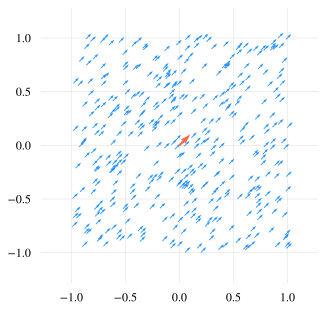

In [18]:
targetPath = f"./data/{model}.h5"
cumsum = True

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPredatorPositionChg = pd.read_hdf(targetPath, key="predatorPositionChg")

TNum = totalPositionX.shape[0] // model.agentsNum

totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPredatorPositionChg = totalPredatorPositionChg.values.reshape(TNum, 2)
totalPredatorVelocity = totalPredatorPositionChg
totalPredatorVelocity[totalPredatorVelocity == 0] = 1e-10

if cumsum:
    totalPositionX += totalPredatorPositionChg.cumsum(axis=0).reshape(TNum, 1, 2)
    totalPredatorPosition = totalPredatorPositionChg.cumsum(axis=0)
else:
    totalPredatorPosition = np.zeros((TNum, 2))
totalVelocityX = np.concatenate([
    np.zeros((1, model.agentsNum, 2)),
    np.diff(totalPositionX, axis=0)
])
totalVelocityX[totalVelocityX == 0] = 1e-10
positionLim = np.max(np.abs(totalPositionX)) * 1.1

# TNum = 100
pbar = tqdm(total=TNum)

def plot_frame(i):
    if model.tqdm:
        pbar.update(1)
    positionX = totalPositionX[i]
    velocityX = totalVelocityX[i]
    predatorPosition = totalPredatorPosition[i]
    predatorVelocity = totalPredatorVelocity[i]

    fig.clear()
    ax1 = plt.subplot(1, 1, 1)
    length = np.sqrt(velocityX[:, 0] ** 2 + velocityX[:, 1] ** 2)
    unitVector = velocityX.copy()
    unitVector[length != 0] /= length[length != 0].reshape(np.sum(length != 0), 1)

    ax1.quiver(
        positionX[:, 0], positionX[:, 1],
        unitVector[:, 0], unitVector[:, 1],
        color='dodgerblue'
    )
    # length = np.sqrt(predatorVelocity[0] ** 2 + predatorVelocity[1] ** 2)
    unitPredatorVector = predatorVelocity.copy()
    # if length != 0:
    #     unitPredatorVector /= length
    ax1.quiver(
        predatorPosition[0], predatorPosition[1],
        unitPredatorVector[0], unitPredatorVector[1],
        color='tomato'
    )
    ax1.set_xlim(-positionLim, positionLim)
    ax1.set_ylim(-positionLim, positionLim)

fig, ax = plt.subplots(figsize=(5, 5))
ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum), interval=50, repeat=False)
ani.save(f"{model}_pointTheta.mp4", dpi=200)

In [14]:
totalPositionX + totalPredatorPositionChg.cumsum(axis=0).reshape(TNum, 1, 2)

array([[[ 0.08680988, -0.44326123],
        [-0.15096482,  0.68955226],
        [-0.99056229, -0.75686176],
        ...,
        [ 0.11069679,  0.07105961],
        [-0.06977414,  0.53572919],
        [ 0.77389394,  0.65961874]],

       [[ 0.08735916, -0.44691814],
        [-0.15176139,  0.69195252],
        [-0.98870132, -0.75486023],
        ...,
        [ 0.1202907 ,  0.07812281],
        [-0.06909569,  0.53659236],
        [ 0.7730572 ,  0.65765669]],

       [[ 0.08680952, -0.44842812],
        [-0.154259  ,  0.69229466],
        [-0.98640922, -0.75261201],
        ...,
        [ 0.11846873,  0.07693633],
        [-0.07034164,  0.53438159],
        [ 0.77819811,  0.65442391]],

       ...,

       [[-0.08359114, -0.70959238],
        [-0.45800918,  0.52955793],
        [-0.97349223, -0.74542638],
        ...,
        [-0.13923262, -0.15682925],
        [-0.25883616,  0.2786322 ],
        [ 0.6766938 ,  0.06834158]],

       [[-0.0842186 , -0.7103623 ],
        [-0.4586969 ,  0.52